<a href="https://colab.research.google.com/github/1ssethDesu/Rice_Disease_ML/blob/main/Rice_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading the dataset**

In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import callbacks
import glob
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = '/content/drive/MyDrive/Rice_disease_detection/Dataset/RiceLeafsDisease'
train_dir = os.path.join(dir, 'train')
val_dir = os.path.join(dir, 'validation')
test_dir = os.path.join(dir, 'test')


In [ ]:
def get_data(dir,data_set):
    data = []
    train_dir = os.path.join(dir, data_set)
    # Correctly define the list of class names
    class_names = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']
    for label in class_names:
        folder = os.path.join(train_dir, label)
        for filename in os.listdir(folder):
            if filename.endswith(('.jpeg', '.jpg', '.png')):
                filepath = os.path.join(folder, filename)
                data.append((filepath, label))
    return pd.DataFrame(data, columns=['filepath', 'label'])

In [ ]:
train = get_data(dir, 'train')
val = get_data(dir,'validation')
test = get_data(dir,'test')

In [ ]:
print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Test set shape: {test.shape}")

Train set shape: (1419, 2)
Validation set shape: (447, 2)
Test set shape: (354, 2)


In [ ]:
print("Training set class distribution:")
print(train['label'].value_counts())

print("\nValidation set class distribution:")
print(val['label'].value_counts())

print("\nTest set class distribution:")
print(test['label'].value_counts())

Training set class distribution:
label
leaf_blast               280
healthy                  280
leaf_scald               280
narrow_brown_spot        280
brown_spot               252
bacterial_leaf_blight     47
Name: count, dtype: int64

Validation set class distribution:
label
leaf_blast               88
healthy                  88
leaf_scald               88
narrow_brown_spot        88
brown_spot               76
bacterial_leaf_blight    19
Name: count, dtype: int64

Test set class distribution:
label
leaf_blast               70
healthy                  70
leaf_scald               70
narrow_brown_spot        70
brown_spot               62
bacterial_leaf_blight    12
Name: count, dtype: int64


# **Data Processing**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE=32
TOTAL_EPOCHS = 50

In [ ]:
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # This splits the data from the source directory
)

train_generator = train_val_datagen.flow_from_directory(
    train_dir, # This directory now contains both train and validation images
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training' # Specifies to get the training portion
)

val_generator = train_val_datagen.flow_from_directory(
    train_dir, # Use the SAME directory as the training generator
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Specifies to get the validation portion
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
    )

Found 1344 images belonging to 6 classes.
Found 336 images belonging to 6 classes.
Found 420 images belonging to 6 classes.


# **Visualizing Samples**

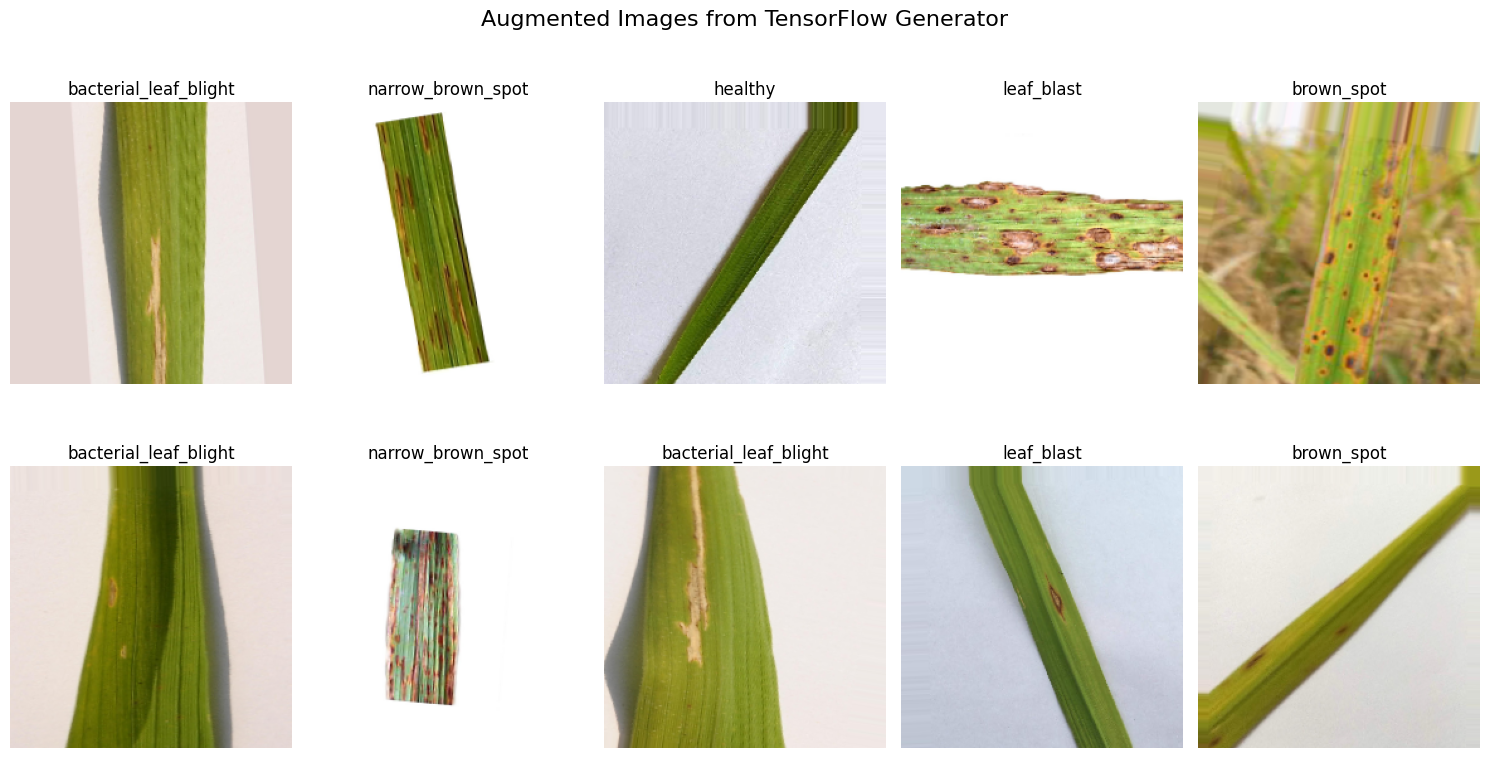

In [ ]:

sample_images, sample_labels = next(train_generator)

# Decode the one-hot encoded labels back to class names
class_indices = train_generator.class_indices
# Create a reverse mapping from index to class name
idx_to_class = {v: k for k, v in class_indices.items()}

# Determine how many images to display (up to 10 or batch size, whichever is smaller)
num_images_to_display_tf = min(10, BATCH_SIZE)

plt.figure(figsize=(15, 8))
for i in range(num_images_to_display_tf):
    # Get the i-th image and label from the batch
    # TensorFlow generator gives NumPy arrays
    sample_image_np_tf = sample_images[i]
    # Find the index of the hot element in the one-hot label
    sample_label_encoded_tf = np.argmax(sample_labels[i])
    sample_class_name_tf = idx_to_class[sample_label_encoded_tf]

    # Display the image in a subplot
    plt.subplot(2, 5, i + 1)
    # Use imshow directly as the image is already in (height, width, channels) format and scaled [0, 1]
    plt.imshow(sample_image_np_tf)
    plt.title(f"{sample_class_name_tf}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Augmented Images from TensorFlow Generator', y=1.02, fontsize=16) # Add a title for clarity
plt.show()


# **Transfer Learning**

## ***InceptionV3 Model***

In [ ]:
NUM_CLASSES = len(train_generator.class_indices)
model = None
latest_epoch = 0
start_epoch = 0

In [ ]:
def build_model(num_classes):
    InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in InceptionV3_model.layers[:-15]:
        layer.trainable = False
    x = InceptionV3_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(units=num_classes, activation='softmax')(x)
    model = Model(InceptionV3_model.input, output)
    return model # Return the model

## ***VGG16 Model***

In [ ]:

def build_vgg16_model(num_classes):
    # Load the VGG16 model with pre-trained weights from ImageNet
    # include_top=False removes the final classification layer, allowing us to add our own
    vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the early layers of the VGG16 base model to prevent their weights from being updated during training.
    # This is a common practice in transfer learning to leverage the learned low-level features.
    # We'll unfreeze later layers for fine-tuning.
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Add custom classification layers on top of the VGG16 base
    x = vgg16_base.output
    x = Flatten()(x) # Flatten the output of the convolutional base
    x = Dense(units=512, activation='relu')(x) # Add a fully connected layer with ReLU activation
    x = Dropout(0.5)(x) # Add dropout for regularization
    x = Dense(units=512, activation='relu')(x) # Add another fully connected layer
    x = Dropout(0.5)(x) # Add another dropout layer
    output = Dense(units=num_classes, activation='softmax')(x) # Output layer with softmax activation for classification

    # Create the final model by combining the VGG16 base and the custom layers
    model = Model(inputs=vgg16_base.input, outputs=output)

    return model


In [ ]:
# Saved Model Directory
inceptionv3_model_folder = "/content/drive/MyDrive/Rice_disease_detection/InceptionV3"
os.makedirs(inceptionv3_model_folder, exist_ok=True)
print(f"Ensured Inceptionv3 model checkpoints directory exists: {inceptionv3_model_folder}")

# # Saved Model Directory
# vgg16_model_folder = "/content/drive/MyDrive/Rice_disease_detection/VGG18_model"
# os.makedirs(vgg16_model_folder, exist_ok=True)
# print(f"Ensured Inceptionv3 model checkpoints directory exists: {vgg16_model_folder}")



Ensured Inceptionv3 model checkpoints directory exists: /content/drive/MyDrive/Rice_disease_detection/VGG18_model


In [ ]:
# Helper function to extract epoch from filenames like '010_best_model.h5'
def get_epoch_from_best_filename(filepath):
    filename_base = os.path.basename(filepath).split('.')[0] # e.g., '010_best_model'
    try:
        return int(filename_base.split('_')[0])
    except ValueError:
        return -1 # Return -1 for files that don't match the pattern or are not numeric

# Try to find existing Keras best model files (e.g., 010_best_model.h5)
best_model_files = glob.glob(os.path.join(vgg16_model_folder, '*_best_model.h5'))

if best_model_files:
    # Find the one with the highest epoch number in its name
    # This automatically picks the latest saved 'best' model
    latest_best_model_path = max(best_model_files, key=get_epoch_from_best_filename)

    try:
        model = load_model(latest_best_model_path)
        print(f"\nLoaded latest best model checkpoint: {latest_best_model_path}")
        latest_epoch = get_epoch_from_best_filename(latest_best_model_path)
        start_epoch = latest_epoch # Resume from this epoch
        print(f"Model was best at epoch {latest_epoch}. Resuming training from epoch {start_epoch + 1}.")
    except Exception as e:
        print(f"Error loading latest best model {latest_best_model_path}: {e}")
        print("Starting training from scratch with a new model.")
        model = build_model(NUM_CLASSES)
else:
    print("No existing best model checkpoints found. Starting training from scratch.")
    # model = build_model(NUM_CLASSES)
    vgg16_model = build_vgg16_model(NUM_CLASSES)


No existing best model checkpoints found. Starting training from scratch.


In [ ]:
# model.summary()
vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,07

 Total params: 27,825,990 (106.15 MB)

 Trainable params: 13,111,302 (50.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg16_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

# checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath=os.path.join(inceptionv3_model_folder, '{epoch:03d}.h5'), # Save with epoch number
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1 # See save messages
# )

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

# --- Start Training ---
print(f"\n--- Starting Training from Epoch {start_epoch + 1} to {TOTAL_EPOCHS} ---")
history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=TOTAL_EPOCHS,          # Train up to this total epoch count
    initial_epoch=start_epoch,    # Start from this epoch (0-indexed)
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[reduce_lr],
    verbose=1
)

print("\n--- Saving the final best model (Method 2) ---")

# Determine the epoch where the best validation loss occurred
# This relies on `restore_best_weights=True` in EarlyStopping.
if 'val_loss' in history.history:
    # `history.history['val_loss']` gives loss for each epoch where training occurred
    # `np.argmin` finds the index of the minimum value.
    # We add `history.epoch[0]` to account for `initial_epoch` if training resumed
    # and then `+ 1` to convert from 0-indexed list to 1-indexed epoch number.

    # Keras history logs epochs from `initial_epoch`.
    # So `history.history['val_loss']` index 0 corresponds to `initial_epoch`.
    # `np.argmin` gives the index within the *current* `history` object.
    best_val_loss_relative_epoch = np.argmin(history.history['val_loss'])
    best_val_loss_actual_epoch = history.epoch[best_val_loss_relative_epoch] + 1

    final_best_model_filename = f"{best_val_loss_actual_epoch:03d}_best_model.h5"
    final_best_model_path = os.path.join(vgg16_model_folder, final_best_model_filename)

    # Save the model. If early_stopping with restore_best_weights=True was used,
    # the 'model' object already holds the weights from the best epoch.
    vgg16_model.save(final_best_model_path)
    print(f"\nFinal best model (from actual epoch {best_val_loss_actual_epoch}) saved to: {final_best_model_path}")
else:
    print("\nCould not determine best epoch to save final model, as 'val_loss' not found in history.")
    # Fallback to saving the model at the last completed epoch
    last_completed_epoch = history.epoch[-1] + 1 if history.epoch else 0
    final_model_filename = f"{last_completed_epoch:03d}_last_epoch_model.h5"
    vgg16_model.save(os.path.join(vgg16_model_folder, final_model_filename))
    print(f"Model at last training state (epoch {last_completed_epoch}) saved to: {os.path.join(vgg16_model_folder, final_model_filename)}")


--- Starting Training from Epoch 1 to 50 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2761 - loss: 1.8525 - precision: 0.3642 - recall: 0.0664 - val_accuracy: 0.5938 - val_loss: 1.2877 - val_precision: 1.0000 - val_recall: 0.0781 - learning_rate: 1.0000e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4755 - loss: 1.3119 - precision: 0.6253 - recall: 0.2098 - val_accuracy: 0.5969 - val_loss: 1.1630 - val_precision: 0.7079 - val_recall: 0.3938 - learning_rate: 1.0000e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5850 - loss: 1.1399 - precision: 0.6996 - recall: 0.3616 - val_accuracy: 0.6313 - val_loss: 1.0353 - val_precision: 0.8103 - val_recall: 0.4406 - learning_rate: 1.0000e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5961 - loss: 1.0805 - precision: 0.6945 - recall: 0.4119 - val_accuracy: 0.6344 - val_loss: 1.0119 - val_precision: 0.7326 - val_recall: 0.4281 - learning_rate: 1.0000e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accu

AttributeError: 'NoneType' object has no attribute 'save'

In [ ]:
# Saved Model Directory
inceptionv3_model_folder = "/content/drive/MyDrive/Rice_disease_detection/InceptionV3"
os.makedirs(inceptionv3_model_folder, exist_ok=True)
print(f"Ensured Inceptionv3 model checkpoints directory exists: {inceptionv3_model_folder}")

# # Saved Model Directory
# vgg16_model_folder = "/content/drive/MyDrive/Rice_disease_detection/VGG18_model"
# os.makedirs(vgg16_model_folder, exist_ok=True)
# print(f"Ensured Inceptionv3 model checkpoints directory exists: {vgg16_model_folder}")



Ensured Inceptionv3 model checkpoints directory exists: /content/drive/MyDrive/Rice_disease_detection/VGG18_model


In [ ]:
# Helper function to extract epoch from filenames like '010_best_model.h5'
def get_epoch_from_best_filename(filepath):
    filename_base = os.path.basename(filepath).split('.')[0] # e.g., '010_best_model'
    try:
        return int(filename_base.split('_')[0])
    except ValueError:
        return -1 # Return -1 for files that don't match the pattern or are not numeric

# Try to find existing Keras best model files (e.g., 010_best_model.h5)
best_model_files = glob.glob(os.path.join(vgg16_model_folder, '*_best_model.h5'))

if best_model_files:
    # Find the one with the highest epoch number in its name
    # This automatically picks the latest saved 'best' model
    latest_best_model_path = max(best_model_files, key=get_epoch_from_best_filename)

    try:
        model = load_model(latest_best_model_path)
        print(f"\nLoaded latest best model checkpoint: {latest_best_model_path}")
        latest_epoch = get_epoch_from_best_filename(latest_best_model_path)
        start_epoch = latest_epoch # Resume from this epoch
        print(f"Model was best at epoch {latest_epoch}. Resuming training from epoch {start_epoch + 1}.")
    except Exception as e:
        print(f"Error loading latest best model {latest_best_model_path}: {e}")
        print("Starting training from scratch with a new model.")
        model = build_model(NUM_CLASSES)
else:
    print("No existing best model checkpoints found. Starting training from scratch.")
    # model = build_model(NUM_CLASSES)
    vgg16_model = build_vgg16_model(NUM_CLASSES)


No existing best model checkpoints found. Starting training from scratch.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# model.summary()
vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,07

 Total params: 27,825,990 (106.15 MB)

 Trainable params: 13,111,302 (50.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg16_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

# checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath=os.path.join(inceptionv3_model_folder, '{epoch:03d}.h5'), # Save with epoch number
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1 # See save messages
# )

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

# --- Start Training ---
print(f"\n--- Starting Training from Epoch {start_epoch + 1} to {TOTAL_EPOCHS} ---")
history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=TOTAL_EPOCHS,          # Train up to this total epoch count
    initial_epoch=start_epoch,    # Start from this epoch (0-indexed)
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[reduce_lr],
    verbose=1
)

print("\n--- Saving the final best model (Method 2) ---")

# Determine the epoch where the best validation loss occurred
# This relies on `restore_best_weights=True` in EarlyStopping.
if 'val_loss' in history.history:
    # `history.history['val_loss']` gives loss for each epoch where training occurred
    # `np.argmin` finds the index of the minimum value.
    # We add `history.epoch[0]` to account for `initial_epoch` if training resumed
    # and then `+ 1` to convert from 0-indexed list to 1-indexed epoch number.

    # Keras history logs epochs from `initial_epoch`.
    # So `history.history['val_loss']` index 0 corresponds to `initial_epoch`.
    # `np.argmin` gives the index within the *current* `history` object.
    best_val_loss_relative_epoch = np.argmin(history.history['val_loss'])
    best_val_loss_actual_epoch = history.epoch[best_val_loss_relative_epoch] + 1

    final_best_model_filename = f"{best_val_loss_actual_epoch:03d}_best_model.h5"
    final_best_model_path = os.path.join(vgg16_model_folder, final_best_model_filename)

    # Save the model. If early_stopping with restore_best_weights=True was used,
    # the 'model' object already holds the weights from the best epoch.
    vgg16_model.save(final_best_model_path)
    print(f"\nFinal best model (from actual epoch {best_val_loss_actual_epoch}) saved to: {final_best_model_path}")
else:
    print("\nCould not determine best epoch to save final model, as 'val_loss' not found in history.")
    # Fallback to saving the model at the last completed epoch
    last_completed_epoch = history.epoch[-1] + 1 if history.epoch else 0
    final_model_filename = f"{last_completed_epoch:03d}_last_epoch_model.h5"
    vgg16_model.save(os.path.join(vgg16_model_folder, final_model_filename))
    print(f"Model at last training state (epoch {last_completed_epoch}) saved to: {os.path.join(vgg16_model_folder, final_model_filename)}")





--- Starting Training from Epoch 20 to 50 ---
Epoch 20/50


## ***MobileNetV2***

In [ ]:
def build_mobilenetv2_model(num_classes):
    # Load the MobileNetV2 model with pre-trained weights from ImageNet
    # include_top=False removes the final classification layer
    mobilenetv2_base = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    mobilenetv2_base.trainable = False

    # Add custom classification layers on top of the base
    x = mobilenetv2_base.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling to reduce spatial dimensions
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(units=num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=mobilenetv2_base.input, outputs=output)

    return model

# Saved Model Directory for MobileNetV2
mobilenetv2_model_folder = "/content/drive/MyDrive/Rice_disease_detection/MobileNetV2"
os.makedirs(mobilenetv2_model_folder, exist_ok=True)
print(f"Ensured MobileNetV2 model checkpoints directory exists: {mobilenetv2_model_folder}")

# Helper function to extract epoch from filenames like '010_best_model.h5'
def get_epoch_from_best_filename(filepath):
    filename_base = os.path.basename(filepath).split('.')[0] # e.g., '010_best_model'
    try:
        return int(filename_base.split('_')[0])
    except ValueError:
        return -1 # Return -1 for files that don't match the pattern or are not numeric

# Try to find existing Keras best model files
best_model_files = glob.glob(os.path.join(mobilenetv2_model_folder, '*_best_model.h5'))

model = None # Initialize model variable
start_epoch = 0 # Initialize start_epoch

if best_model_files:
    # Find the one with the highest epoch number in its name
    latest_best_model_path = max(best_model_files, key=get_epoch_from_best_filename)

    try:
        model = load_model(latest_best_model_path)
        print(f"\nLoaded latest best MobileNetV2 model checkpoint: {latest_best_model_path}")
        latest_epoch = get_epoch_from_best_filename(latest_best_model_path)
        start_epoch = latest_epoch # Resume from this epoch
        print(f"MobileNetV2 model was best at epoch {latest_epoch}. Resuming training from epoch {start_epoch + 1}.")
    except Exception as e:
        print(f"Error loading latest best MobileNetV2 model {latest_best_model_path}: {e}")
        print("Starting training MobileNetV2 from scratch with a new model.")
        model = build_mobilenetv2_model(NUM_CLASSES)
else:
    print("No existing MobileNetV2 best model checkpoints found. Starting training from scratch.")
    model = build_mobilenetv2_model(NUM_CLASSES)


model.summary()

# Compile the MobileNetV2 model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Start with a slightly higher LR, can reduce later
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

# Define callbacks
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3, # Increased patience slightly
    min_lr=1e-8
)

# Use ModelCheckpoint to save the best model during training based on validation loss
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(mobilenetv2_model_folder, '{epoch:03d}_best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Use EarlyStopping to stop training when validation loss stops improving
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7, # Patience before stopping
    mode='min',
    restore_best_weights=True, # Restore weights from the epoch with best val_loss
    verbose=1
)


# --- Start Training MobileNetV2 ---
print(f"\n--- Starting MobileNetV2 Training from Epoch {start_epoch + 1} to {TOTAL_EPOCHS} ---")
history_mobilenetv2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=TOTAL_EPOCHS,
    initial_epoch=start_epoch,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[reduce_lr, checkpoint_callback, early_stopping], # Include checkpoint and early stopping
    verbose=1
)

print("\n--- Saving the final MobileNetV2 model ---")

# When EarlyStopping with `restore_best_weights=True` is used,
# the `model` object automatically has the weights from the best epoch
# after training finishes (either by completing epochs or early stopping).
# So, we just save the model state as it is.

# Determine the epoch where early stopping occurred or last epoch if no early stopping
final_epoch = history_mobilenetv2.epoch[-1] + 1

# If EarlyStopping was triggered and restored best weights,
# the best epoch was determined by the callback.
# We can try to find the actual best epoch from the history if needed,
# but saving the model after training is typically enough when restore_best_weights=True.
# However, saving with the *actual* best epoch number in the filename is good practice.

# Find the actual best epoch from history (if available) or use the last epoch
if 'val_loss' in history_mobilenetv2.history:
    best_val_loss_relative_epoch = np.argmin(history_mobilenetv2.history['val_loss'])
    # history.epoch gives the actual epoch numbers trained for each step in history.
    # index `best_val_loss_relative_epoch` corresponds to this list.
    if history_mobilenetv2.epoch: # Check if history.epoch is not empty
        best_val_loss_actual_epoch = history_mobilenetv2.epoch[best_val_loss_relative_epoch] + 1
    else: # Fallback if no epochs were recorded in history (unlikely after fit runs)
         best_val_loss_actual_epoch = final_epoch # Default to last epoch trained


    final_best_model_filename = f"{best_val_loss_actual_epoch:03d}_best_model.h5"
    final_best_model_path = os.path.join(mobilenetv2_model_folder, final_best_model_filename)

    # Save the model with the name indicating the actual best epoch
    model.save(final_best_model_path)
    print(f"\nMobileNetV2 model (from actual best epoch {best_val_loss_actual_epoch}) saved to: {final_best_model_path}")
else:
    print("\nCould not determine best epoch to save final MobileNetV2 model, as 'val_loss' not found in history.")
    # Fallback to saving the model at the last completed epoch
    last_completed_epoch = history_mobilenetv2.epoch[-1] + 1 if history_mobilenetv2.epoch else 0
    final_model_filename = f"{last_completed_epoch:03d}_last_epoch_model.h5"
    final_model_path = os.path.join(mobilenetv2_model_folder, final_model_filename)
    model.save(final_model_path)
    print(f"MobileNetV2 model at last training state (epoch {last_completed_epoch}) saved to: {final_model_path}")



# **Model Evaluation**

In [ ]:
# --- Evaluate the final (or best restored) model ---
print("\n--- Evaluating Final Model on Test Set ---")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    test_generator,
    steps=int(np.ceil(test_generator.samples / BATCH_SIZE)),
    verbose=1
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
pri+nt(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


--- Evaluating Final Model on Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 280s 22s/step - accuracy: 0.9442 - loss: 0.1885 - precision: 0.9527 - recall: 0.9424
Test Loss: 0.2164
Test Accuracy: 0.9333
Test Precision: 0.9422
Test Recall: 0.9310



--- Plotting Training and Validation Metrics ---


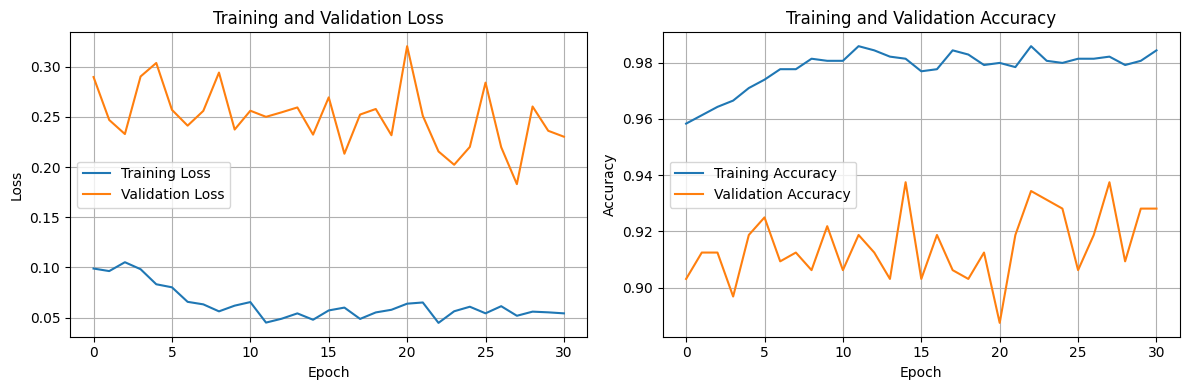

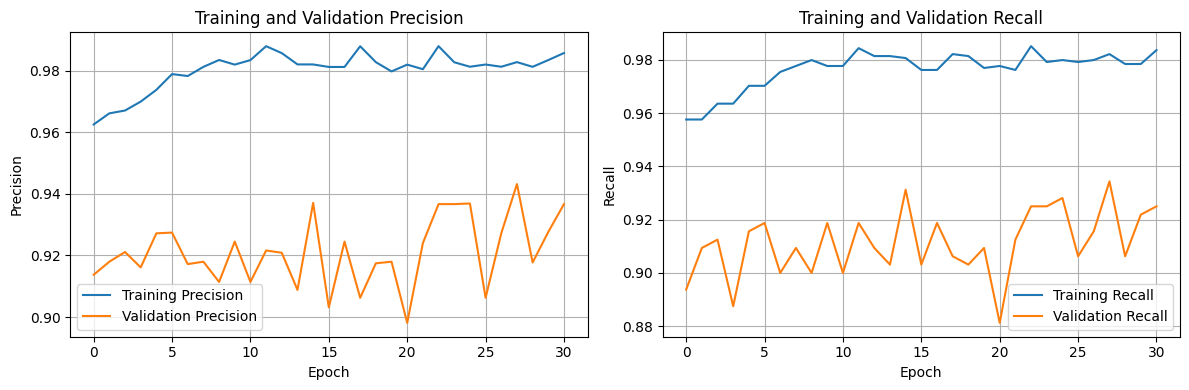

In [ ]:

print("\n--- Plotting Training and Validation Metrics ---")

# Get the list of epochs
epochs = range(len(history.history['accuracy']))

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

# Plot Training and Validation Precision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['precision'], label='Training Precision')
plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


# Plot Training and Validation Recall
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['recall'], label='Training Recall')
plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


--- Making Predictions on Test Set ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 300s 22s/step

Sample Predictions vs True Labels:
Image: bacterial_leaf_blight/bacterial_leaf_blight (1).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (119).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (121).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (126).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (128).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (136).jpg, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_leaf_blight/bacterial_leaf_blight (14).JPG, True: bacterial_leaf_blight, Predicted: bacterial_leaf_blight
Image: bacterial_l

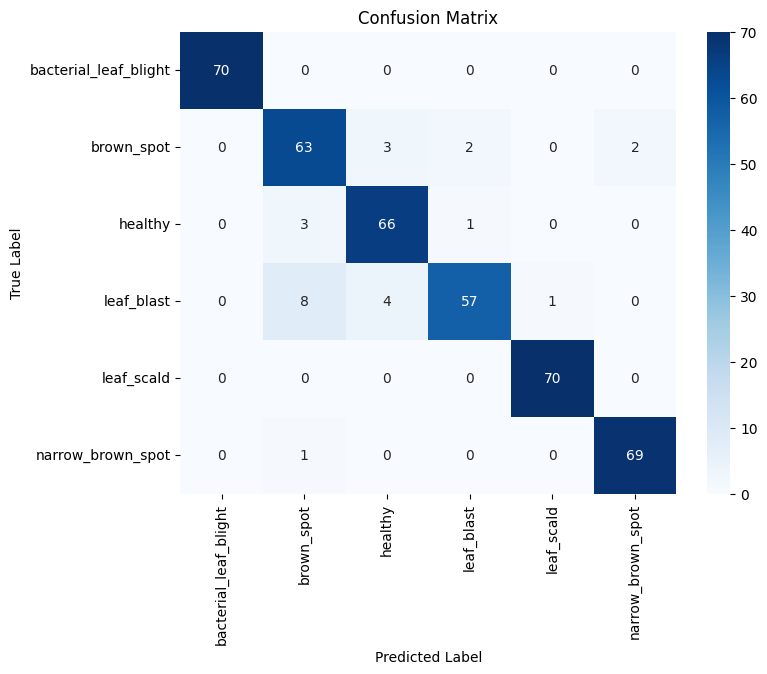

In [ ]:
print("\n--- Making Predictions on Test Set ---")

# Predict the probabilities for each class on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Get the predicted class indices (the class with the highest probability)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true class indices from the test generator
true_class_indices = test_generator.classes

# Get the class names from the test generator's class_indices
class_names = list(test_generator.class_indices.keys())

# Map the predicted and true indices to class names
predicted_classes = [class_names[i] for i in predicted_class_indices]
true_classes = [class_names[i] for i in true_class_indices]

# Optional: Print the first few predictions and true labels
print("\nSample Predictions vs True Labels:")
for i in range(min(10, len(test_generator.filenames))): # Print for the first 10 images
    print(f"Image: {test_generator.filenames[i]}, True: {true_classes[i]}, Predicted: {predicted_classes[i]}")

# Optional: Generate and print a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


--- Performing Predictions on Test Images ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step

--- Classification Report ---
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00        70
           brown_spot       0.84      0.90      0.87        70
              healthy       0.90      0.94      0.92        70
           leaf_blast       0.95      0.81      0.88        70
           leaf_scald       0.99      1.00      0.99        70
    narrow_brown_spot       0.97      0.99      0.98        70

             accuracy                           0.94       420
            macro avg       0.94      0.94      0.94       420
         weighted avg       0.94      0.94      0.94       420


--- Confusion Matrix ---


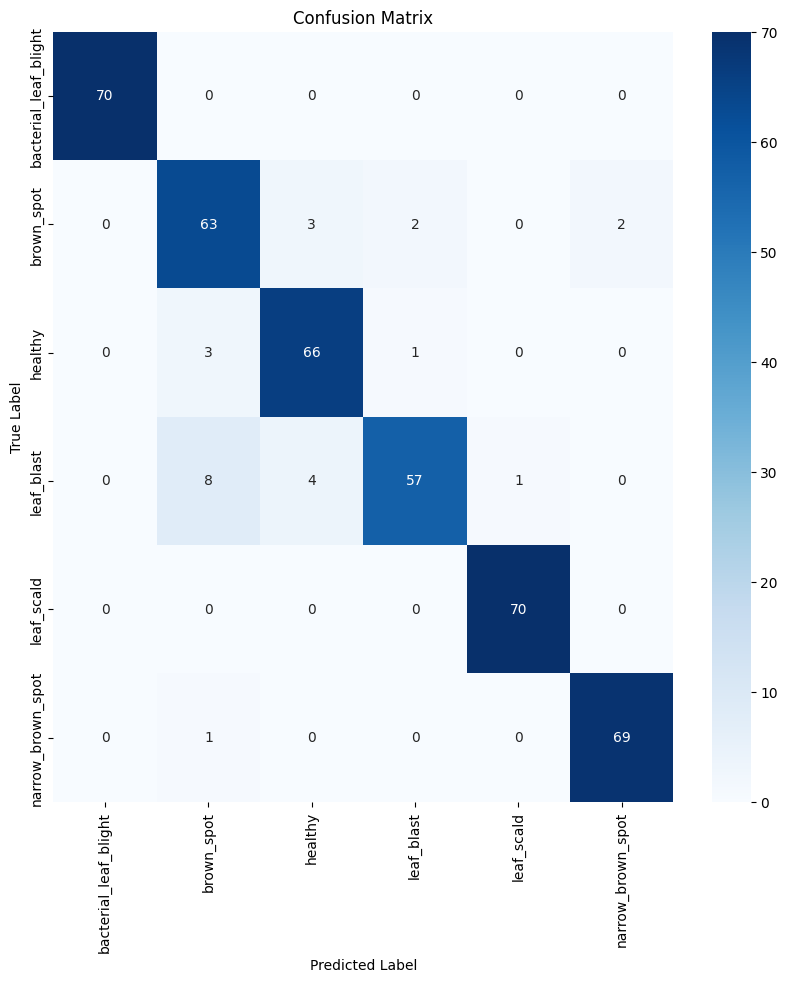


--- Displaying Sample Test Images with Predictions ---


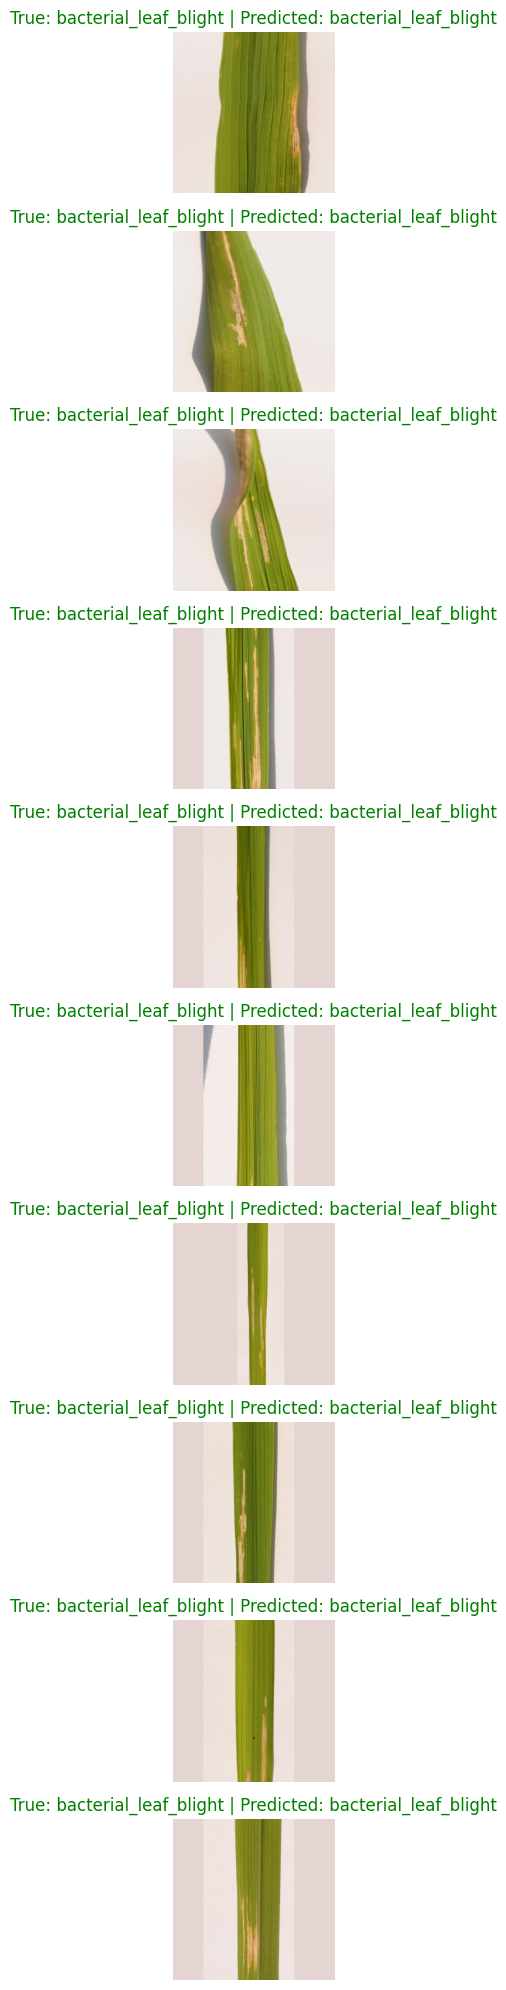


--- Prediction and Advanced Evaluation Complete ---


In [ ]:
print("\n--- Performing Predictions on Test Images ---")

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_class_indices = np.argmax(predictions, axis=1)

true_class_indices = test_generator.classes
class_names = list(test_generator.class_indices.keys())

predicted_classes = [class_names[i] for i in predicted_class_indices]
true_classes = [class_names[i] for i in true_class_indices]

print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# =====================================================================
# --- Displaying Sample Test Images with Predictions ---
# =====================================================================

print("\n--- Displaying Sample Test Images with Predictions ---")

# Load a few actual test images and their labels
# The test_generator.filepaths contains the full paths to the images.
num_images_to_display = 10 # You can change this number

plt.figure(figsize=(15, num_images_to_display * 2)) # Adjust figure size dynamically

for i in range(min(num_images_to_display, test_generator.samples)):
    plt.subplot(num_images_to_display, 1, i + 1) # (rows, columns, plot_number)

    # Get the image path
    image_path = test_generator.filepaths[i]
    # Read the image using matplotlib.image.imread
    img = plt.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off') # Hide axes for cleaner display

    # Get true and predicted labels
    true_label = true_classes[i]
    predicted_label = predicted_classes[i]

    # Set title for each image
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label} | Predicted: {predicted_label}", color=title_color, fontsize=12)

plt.tight_layout()
plt.show()

print("\n--- Prediction and Advanced Evaluation Complete ---")